# <center>DATA643: Recommender System </center>
## <center> Final Project </center>
### <i> <center> Harpreet Shoker, Rose Koh, Summer 2018 </center> </i>

## Notebook2_Exploratory Data Analysis
The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.  For each user, 4 and 100 of their orders are given, with the sequence of products purchased in each order.

---

## Data
orders (3.4m rows, 206k users):

* order_id: order identifier
* user_id: customer identifier
* eval_set: which evaluation set this order belongs in (see SET described below)
* order_number: the order sequence number for this user (1 = first, n = nth)
* order_dow: the day of the week the order was placed on
* order_hour_of_day: the hour of the day the order was placed on
* days_since_prior: days since the last order, capped at 30 (with NAs for order_number = 1)

products (50k rows):

* product_id: product identifier
* product_name: name of the product
* aisle_id: foreign key
* department_id: foreign key

aisles (134 rows):

* aisle_id: aisle identifier
* aisle: the name of the aisle

deptartments (21 rows):

* department_id: department identifier
* department: the name of the department

order_products__SET (30m+ rows):

* order_id: foreign key
* product_id: foreign key
* add_to_cart_order: order in which each product was added to cart
* reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

where SET is one of the four following evaluation sets (eval_set in orders):

* "prior": orders prior to that users most recent order (~3.2m orders)
* "train": training data supplied to participants (~131k orders)
* "test": test data reserved for machine learning competitions (~75k orders)

---

## Get Data

In [1]:
data_url = 'https://www.kaggle.com/c/6644/download-all'

# Define download location
import os

datasets_path = os.path.join(os.getcwd(), 'data')
dt_path = os.path.join(datasets_path, 'all.zip')

In [2]:
# Proceed download
import urllib

file = urllib.request.urlretrieve(data_url, dt_path)

In [3]:
# Extract the zip file
import zipfile, fnmatch

if fnmatch.fnmatch(datasets_path,"*.zip"):
    with zipfile.ZipFile(zfn,mode='r') as z:
        z.extractall(datasets_path)

In [4]:
from subprocess import check_output
print(check_output(["ls", "./data/all"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [5]:
aisles_path = os.path.join(datasets_path, 'all', 'aisles.csv')
departments_path = os.path.join(datasets_path, 'all', 'departments.csv')
order_products__prior_path = os.path.join(datasets_path, 'all', 'order_products__prior.csv')
order_products__train_path = os.path.join(datasets_path, 'all', 'order_products__train.csv')
orders_path = os.path.join(datasets_path, 'all', 'orders.csv')
products_path = os.path.join(datasets_path, 'all', 'products.csv')

## Load Data

In [6]:
# Load Necessary Modules

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [7]:

aisles_df = pd.read_csv(aisles_path)
print("aisles", aisles_df.shape)
aisles_df.head(5)


aisles (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [8]:

departments_df = pd.read_csv(departments_path)
print("departments", departments_df.shape)
departments_df.head()


departments (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [9]:

order_products_prior_df = pd.read_csv(order_products__prior_path)
print("order_products__prior", order_products_prior_df.shape)
order_products_prior_df.head()


order_products__prior (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:

order_products_train_df = pd.read_csv(order_products__train_path)
print("order_products__train", order_products_train_df.shape)
order_products_train_df.head()


order_products__train (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [11]:

orders_df = pd.read_csv(orders_path)
print("orders", orders_df.shape)
orders_df.head()


orders (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [12]:
orders_df['user_id'].nunique()

206209

In [13]:

products_df = pd.read_csv(products_path)
print("products", products_df.shape)
products_df.head()


products (49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In this dataset, 4 to 100 orders of a customer are given and our objective is to predict the products that will be purchased again.  The last order of the user has been taken out and divided into train and test sets.  All the prior order information of the customer are present in order_products_prior file.  We can also note that there is a column in `orders.csv` called eval_set which tells us as to which of the three datasets (prior, train or test) the given row goes to.

`order_products*.csv` file has more detailed information about the products that had been bought in the given order along with the re-ordered status.

## EDA

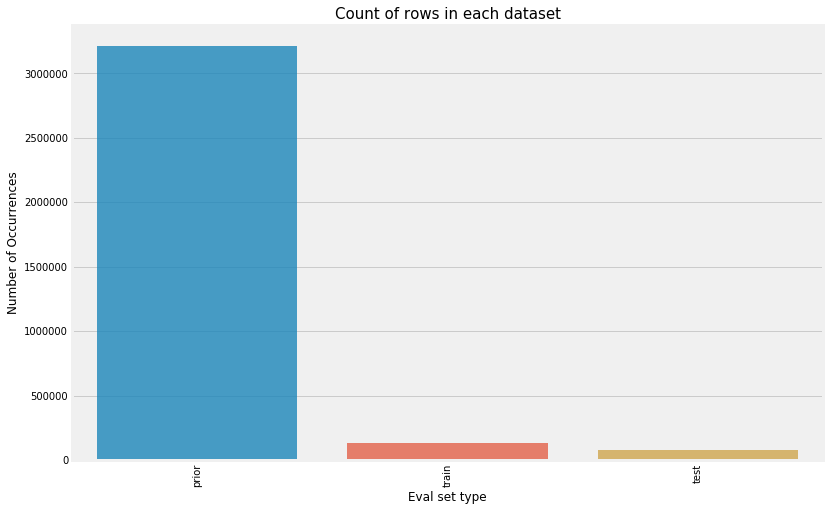

In [14]:
count_users = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(count_users.index, count_users.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [15]:
count_users = orders_df.groupby("eval_set")["user_id"].nunique()
count_users

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

* Total customers: 206,209
* The last purchase of 131,209 customers are given as trainset.
* Our objective is to predict the 75000 customers' next purchase.

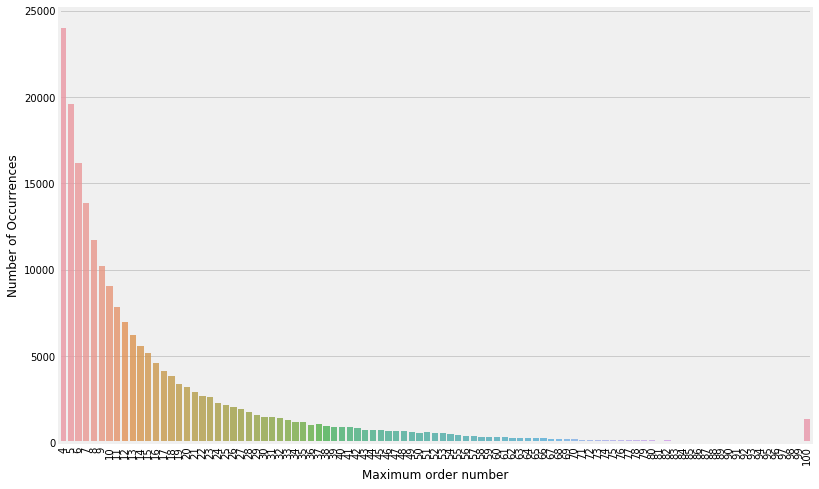

In [16]:
count_users_order = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
count_users_order = count_users_order.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(count_users_order.index, count_users_order.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()


* Users order range is 4 ~ 100 as described in data description.

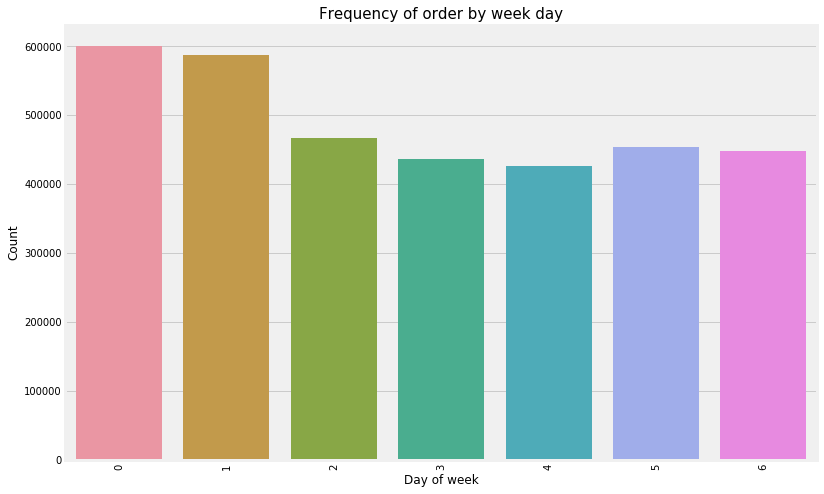

In [18]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

* The amount of orders are high on Saturdays(0) and Sundays(1)
* The amount of orders seems low on Wednesdays(4)

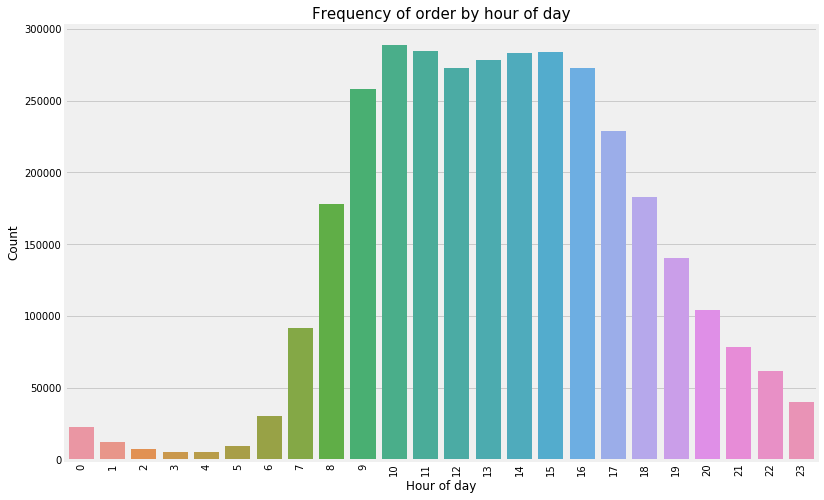

In [20]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

* So majority of the orders are made during day time (9 ~ 16)

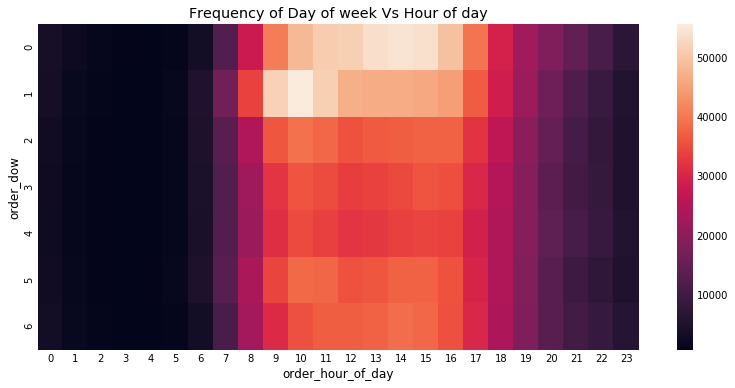

In [21]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

* The heatmap shows Saturday(0) evenings and Sunday(1) mornings are the prime time for orders.

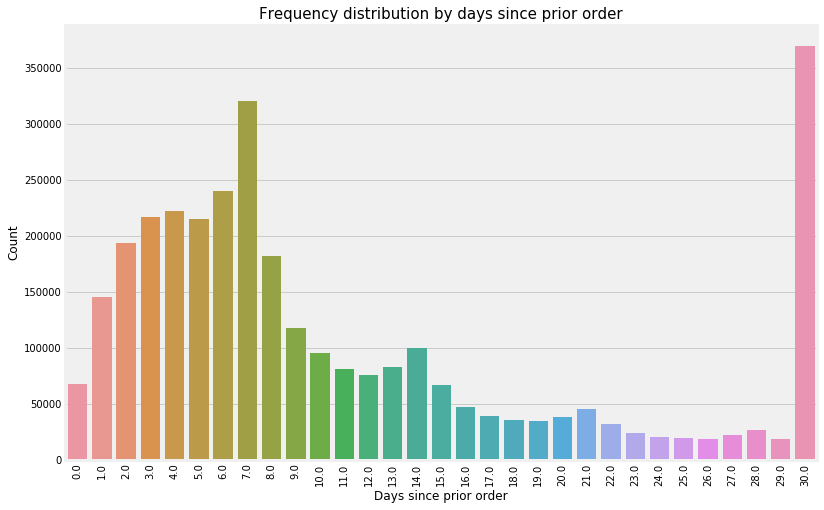

In [24]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

* Customers order once in every week (7.0) or once in every 30 days (30.0).
* smaller peaks at 14.0, 21.0, 28.0 shows weekly intervals.

As our objective is to figure out the re-purchases, let's check out the re-purchase percentage in prior and train set.


In [27]:
# percentage of re-orders in prior set #
repurchase_prior = order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]
# percentage of re-orders in train set #
repurchase_train = order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

print("re-purchase percentage in prior set: ", round(repurchase_prior,4))
print("re-purchase percentage in train set: ", round(repurchase_train,4))

re-purchase percentage in prior set:  0.5897
re-purchase percentage in train set:  0.5986


* On average, about 59% of the products in an order are re-purchased.

In [31]:

grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]


1    0.879151
0    0.120849
Name: reordered, dtype: float64

* 12% of the orders in prior set has no re-purchased items

In [32]:

grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]


1    0.93444
0    0.06556
Name: reordered, dtype: float64

* 6.5% of the orders in train set has no re-purchased items

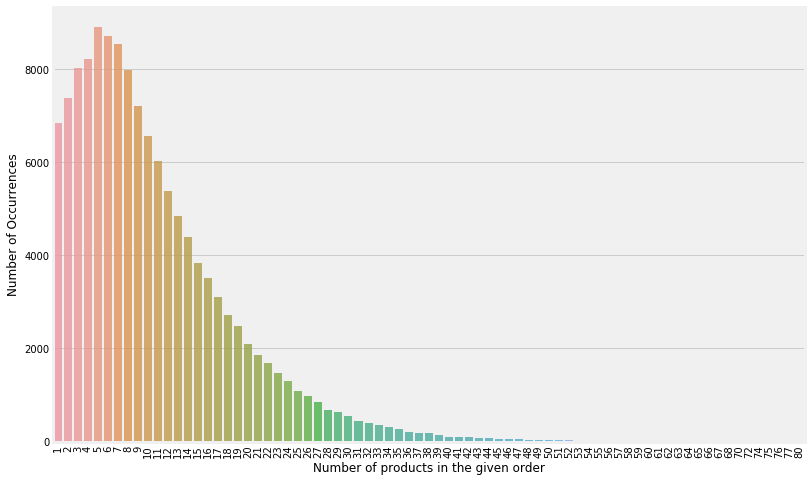

In [35]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
count_orders = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(count_orders.index, count_orders.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

* Number of products bought in each other shows left skewed distribution with maximum value of 5.

In [36]:
# Merge product details with order_prior_details
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [37]:
count_product = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
count_product.columns = ['product_name', 'frequency_count']
count_product

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


* Most of them are organic products
* Majority of them are fruits

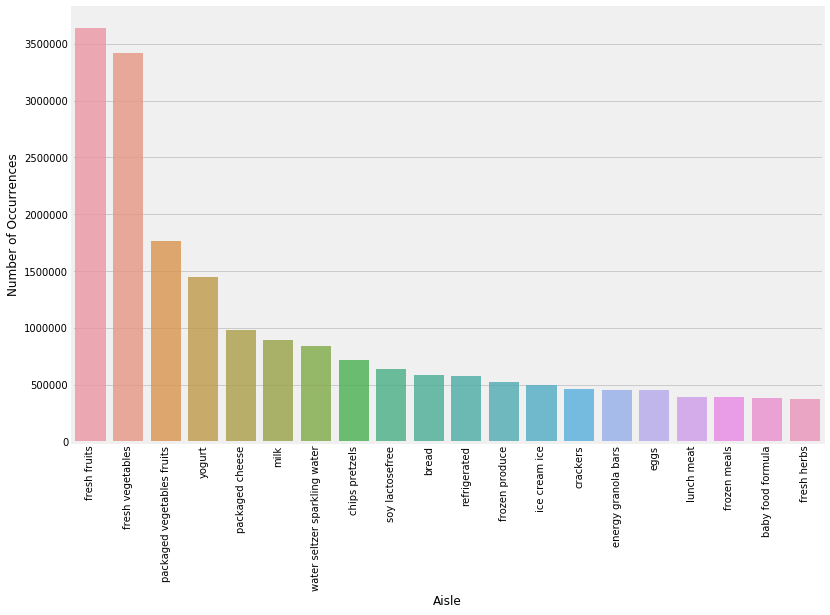

In [38]:
count_aisle = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(count_aisle.index, count_aisle.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The top two aisles are:
    * fresh fruits
    * fresh vegetables

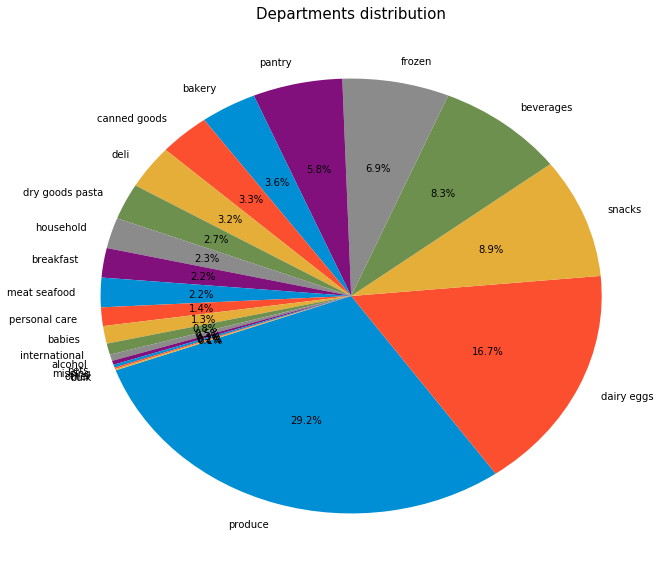

In [39]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

* The largest department is produce by 29.2%

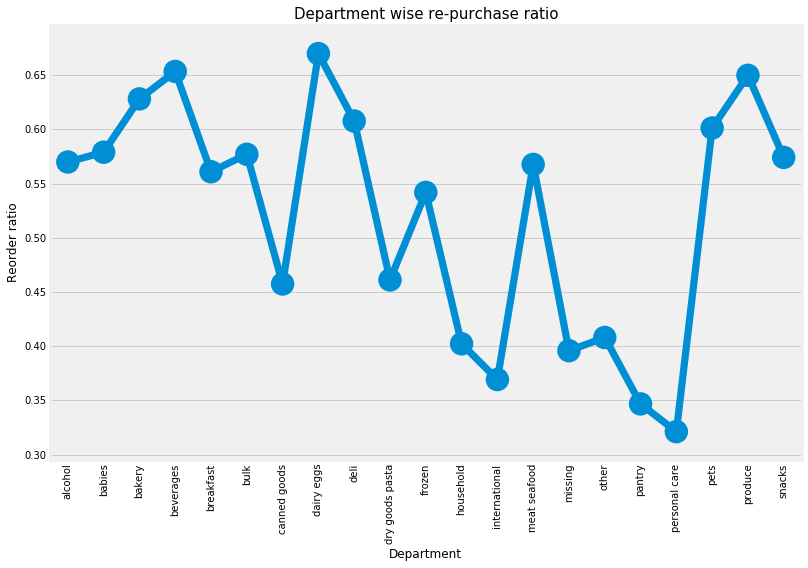

In [42]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise re-purchase ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

* Repurchase ratio shows highest: diary eggs and lowest: personal care.

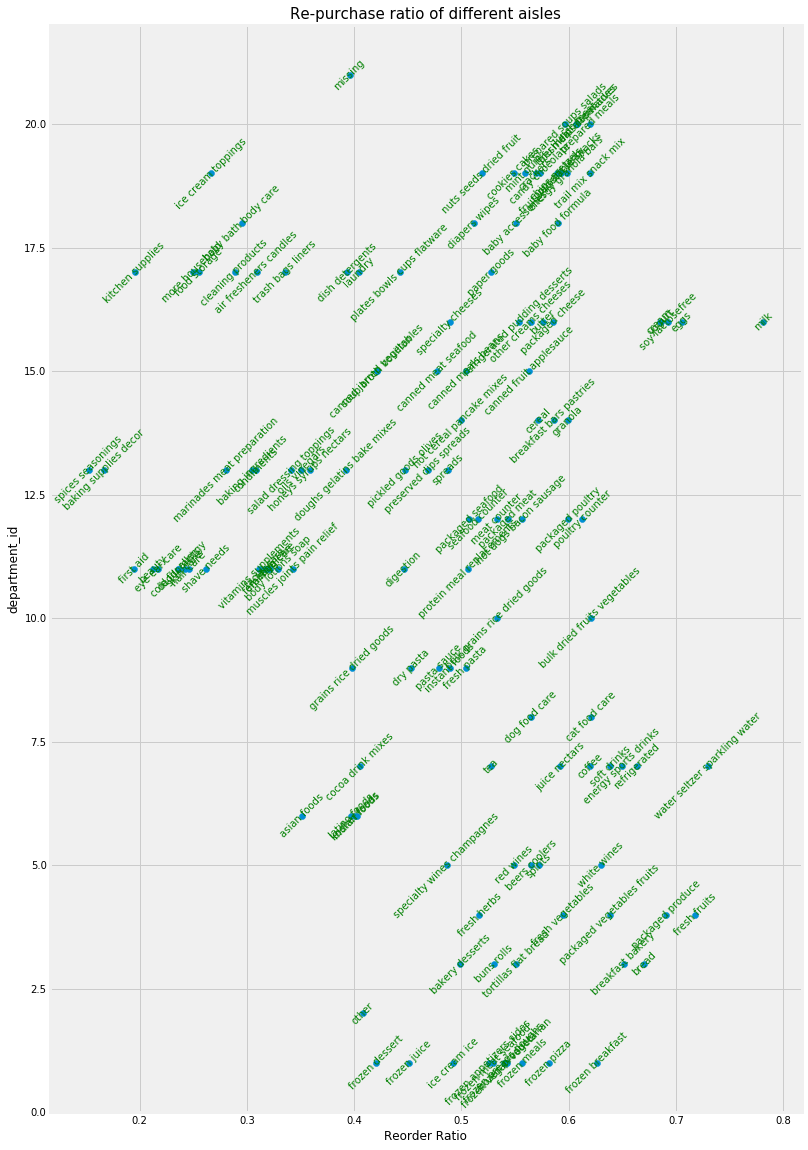

In [43]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Re-purchase ratio of different aisles", fontsize=15)
plt.show()

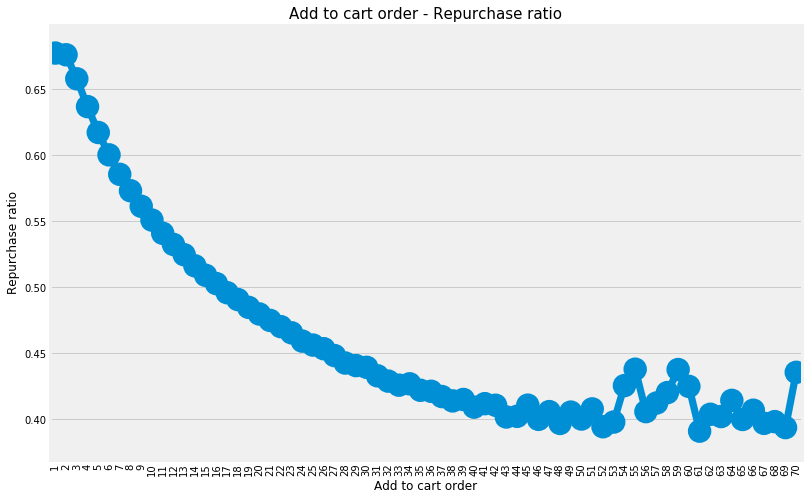

In [49]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].loc[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, size=0.1)
plt.ylabel('Repurchase ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Repurchase ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

* The products that are added to the cart at first, are more likely to be re-purchased.
z

In [53]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()


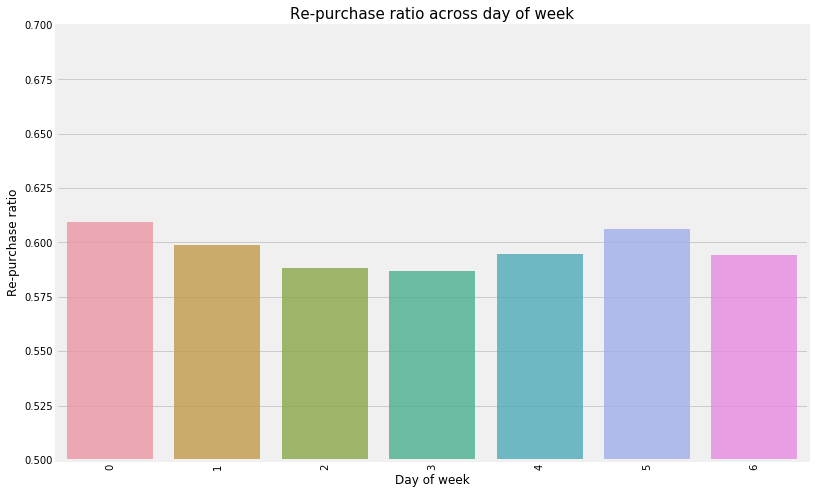

In [54]:
plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8)
plt.ylabel('Re-purchase ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Re-purchase ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

In [55]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()


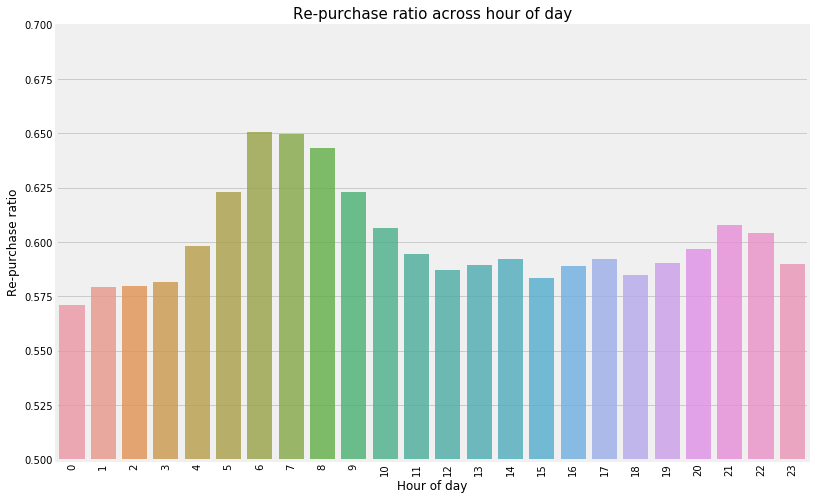

In [58]:
plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8)
plt.ylabel('Re-purchase ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Re-purchase ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()


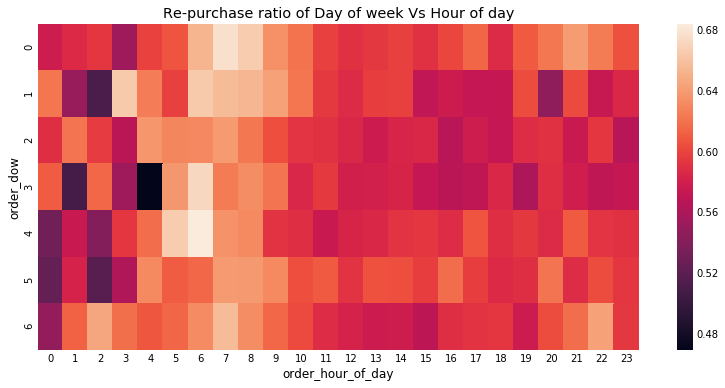

In [59]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Re-purchase ratio of Day of week Vs Hour of day")
plt.show()


* Re-purchase ratios are quite high during the early mornings compared to later half of the day